# Leveraging Transfer Learning on Pre-Trained EfficientNet Models for Early Pneumonia Classification in Chest X-ray Images

This notebook implements a pneumonia classification model using transfer learning on EfficientNet-B0, focusing on early detection. We address dataset curation, preprocessing with GAN-based augmentation for class balance and early-stage representation, model fine-tuning, interpretability, and robust evaluation.

## Objectives
- Explore clinical and imaging characteristics of pneumonia via literature and dataset analysis.
- Curate and preprocess the Chest X-ray Pneumonia dataset, using Conditional WGAN-GP for synthetic data to mitigate imbalances and enhance early-stage features.
- Deploy pre-trained EfficientNet-B0 with parameter-efficient fine-tuning and Grad-CAM for interpretability.
- Evaluate robustness with precision, recall, F1-score, MCC, ensemble benchmarking, and external generalizability tests.

Looking in indexes: https://download.pytorch.org/whl/cu121
Mounted at /content/drive
Class Distribution:
                 Count
train/NORMAL      1341
train/PNEUMONIA   3875
val/NORMAL          70
val/PNEUMONIA       70
test/NORMAL        234
test/PNEUMONIA     390


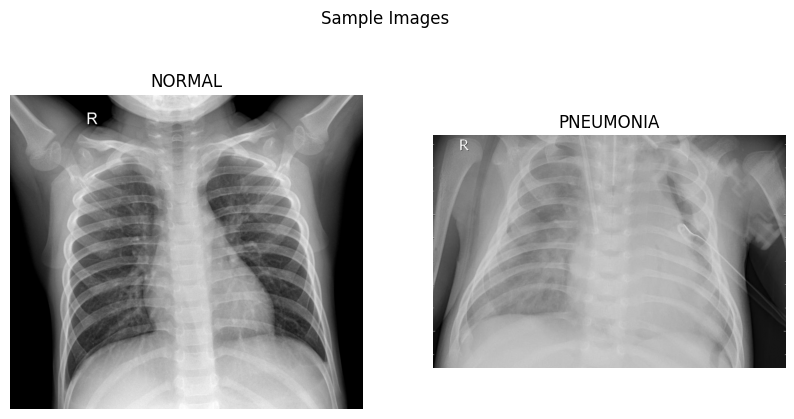

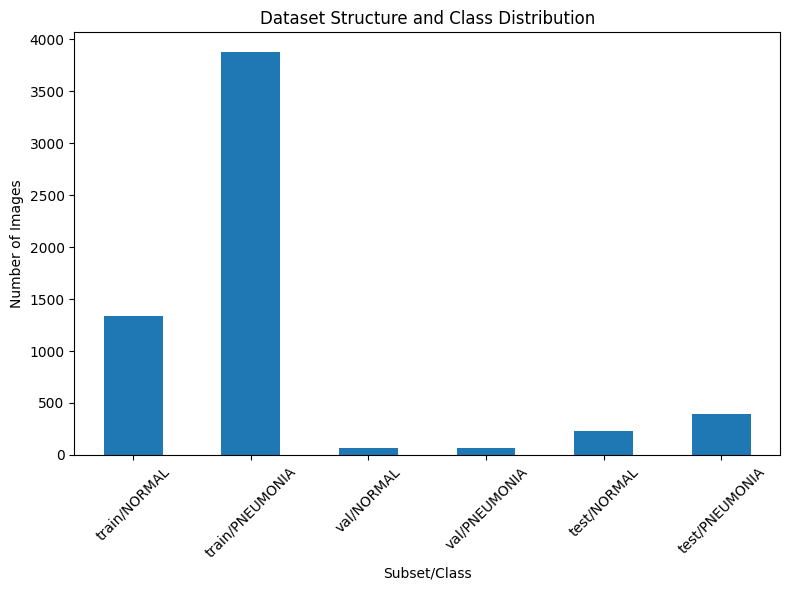

Data loading, EDA, and preprocessing complete. Preprocessed data saved to Google Drive.


In [ ]:
# Install necessary libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install opencv-python pillow numpy matplotlib pandas

# Import modules
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/PNEUMONIA/'
dataset_path = os.path.join(base_path, 'chest_xray')
preprocessed_path = os.path.join(base_path, 'preprocessed')
results_path = os.path.join(base_path, 'results')
os.makedirs(preprocessed_path, exist_ok=True)
os.makedirs(os.path.join(preprocessed_path, 'train/NORMAL'), exist_ok=True)
os.makedirs(os.path.join(preprocessed_path, 'train/PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(preprocessed_path, 'val/NORMAL'), exist_ok=True)
os.makedirs(os.path.join(preprocessed_path, 'val/PNEUMONIA'), exist_ok=True)
os.makedirs(os.path.join(preprocessed_path, 'test/NORMAL'), exist_ok=True)
os.makedirs(os.path.join(preprocessed_path, 'test/PNEUMONIA'), exist_ok=True)
os.makedirs(results_path, exist_ok=True)

# EDA: Count images
def count_images(folder):
    counts = {}
    for sub in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(folder, sub, cls)
            if os.path.exists(path):
                counts[f'{sub}/{cls}'] = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    return counts

counts = count_images(dataset_path)
df = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])
print("Class Distribution:")
print(df)

# Visualize samples
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i, cls in enumerate(['NORMAL', 'PNEUMONIA']):
    path = os.path.join(dataset_path, 'train', cls)
    img_files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if img_files:
        img = Image.open(os.path.join(path, img_files[0]))
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(cls)
        axs[i].axis('off')
plt.suptitle('Sample Images')
plt.savefig(os.path.join(results_path, 'sample_images.png'))
plt.show()

# Bar plot for distribution
plt.figure(figsize=(8, 6))
df['Count'].plot(kind='bar')
plt.title('Dataset Structure and Class Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Subset/Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'class_distribution.png'))
plt.show()

# Preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom dataset for loading original images
class OriginalDataset(Dataset):
    def __init__(self, root, transform=None):
        self.images = []
        self.labels = []
        self.transform = transform
        for cls in ['NORMAL', 'PNEUMONIA']:
            sub_path = os.path.join(root, cls)
            if os.path.exists(sub_path):
                label = 0 if cls == 'NORMAL' else 1
                img_files = [f for f in os.listdir(sub_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                for img in img_files:
                    self.images.append(os.path.join(sub_path, img))
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# Preprocess and save function
def preprocess_and_save(sub):
    input_path = os.path.join(dataset_path, sub)
    output_path = os.path.join(preprocessed_path, sub)
    os.makedirs(output_path, exist_ok=True)
    dataset = OriginalDataset(input_path, transform=transform)
    for i in range(len(dataset)):
        img, label = dataset[i]
        cls_dir = 'NORMAL' if label == 0 else 'PNEUMONIA'
        save_dir = os.path.join(output_path, cls_dir)
        os.makedirs(save_dir, exist_ok=True)
        torch.save(img, os.path.join(save_dir, f'preprocessed_{sub}_{cls_dir}_{i}.pt'))

# Preprocess each subset
for sub in ['train', 'val', 'test']:
    preprocess_and_save(sub)

print('Data loading, EDA, and preprocessing complete. Preprocessed data saved to Google Drive.')

In [ ]:
# Import modules
import os
from google.colab import drive
import shutil
import random

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/PNEUMONIA/'
preprocessed_path = os.path.join(base_path, 'preprocessed')

# Adjust validation set: Move ~20 images per class from train to val
for cls in ['NORMAL', 'PNEUMONIA']:
    train_dir = os.path.join(preprocessed_path, 'train', cls)
    val_dir = os.path.join(preprocessed_path, 'val', cls)
    os.makedirs(val_dir, exist_ok=True)
    train_files = [f for f in os.listdir(train_dir) if f.endswith('.pt')]
    if len(train_files) > 20:
        random.shuffle(train_files)
        to_move = train_files[:20]
        for f in to_move:
            src = os.path.join(train_dir, f)
            dst = os.path.join(val_dir, f)
            if os.path.exists(src):
                shutil.move(src, dst)

print('Validation set adjusted by adding ~20 images per class from training set. Updated data in Google Drive.')

Mounted at /content/drive
Validation set adjusted by adding ~20 images per class from training set. Updated data in Google Drive.


In [ ]:
# Install libraries
!pip install torch torchvision

# Import modules
import os
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import numpy as np

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/PNEUMONIA/'
preprocessed_path = os.path.join(base_path, 'preprocessed')
synthetic_path = os.path.join(base_path, 'synthetic')
models_path = os.path.join(base_path, 'models')
os.makedirs(synthetic_path, exist_ok=True)
os.makedirs(os.path.join(synthetic_path, 'NORMAL'), exist_ok=True)
os.makedirs(models_path, exist_ok=True)

# Custom dataset for GAN (only NORMAL class from train)
class GANChestDataset(Dataset):
    def __init__(self, root):
        self.images = []
        self.labels = []
        cls = 'NORMAL'
        sub_path = os.path.join(root, cls)
        label = 0  # Only NORMAL
        for f in os.listdir(sub_path):
            if f.endswith('.pt'):
                self.images.append(os.path.join(sub_path, f))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = torch.load(self.images[idx])
        return img, self.labels[idx]

# Load dataset (only train/NORMAL)
gan_dataset = GANChestDataset(os.path.join(preprocessed_path, 'train'))
dataloader = DataLoader(gan_dataset, batch_size=32, shuffle=True)

# Generator model
class Generator(nn.Module):
    def __init__(self, nz=100, num_classes=2, img_size=224, channels=3):
        super(Generator, self).__init__()
        self.embed = nn.Embedding(num_classes, nz)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(nz * 2, 512, 7, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        embed = self.embed(labels)
        input = torch.cat((z, embed), dim=1).view(z.size(0), -1, 1, 1)
        return self.model(input)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, num_classes=2, img_size=224, channels=3):
        super(Discriminator, self).__init__()
        self.embed = nn.Embedding(num_classes, img_size * img_size)
        self.model = nn.Sequential(
            nn.Conv2d(channels + 1, 32, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 7, 1, 0, bias=False),
        )

    def forward(self, img, labels):
        embed = self.embed(labels).view(labels.size(0), 1, 224, 224)
        input = torch.cat((img, embed), dim=1)
        return self.model(input).view(-1)

# Compute gradient penalty
def compute_gp(D, real, fake, labels, device):
    alpha = torch.rand(real.size(0), 1, 1, 1, device=device)
    interpolates = alpha * real + (1 - alpha) * fake
    interpolates.requires_grad_(True)
    disc_interpolates = D(interpolates, labels)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True,
        retain_graph=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nz = 100
G = Generator(nz).to(device)
D = Discriminator().to(device)
optim_g = optim.Adam(G.parameters(), lr=0.0001, betas=(0.0, 0.9))
optim_d = optim.Adam(D.parameters(), lr=0.0001, betas=(0.0, 0.9))

# Load checkpoint if exists
checkpoint_path = os.path.join(models_path, 'wgan_gp_checkpoint.pt')
start_epoch = 0
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    G.load_state_dict(checkpoint['G'])
    D.load_state_dict(checkpoint['D'])
    optim_g.load_state_dict(checkpoint['optim_g'])
    optim_d.load_state_dict(checkpoint['optim_d'])
    start_epoch = checkpoint['epoch']

# Training parameters
lambda_gp = 10
n_critic = 5
epochs = 50

# Train loop
for epoch in range(start_epoch, epochs):
    for i, (real, labels) in enumerate(dataloader):
        real = real.to(device)
        labels = labels.to(device)

        # Train Discriminator
        for _ in range(n_critic):
            optim_d.zero_grad()
            fake_z = torch.randn(real.size(0), nz, device=device)
            fake = G(fake_z, labels)
            d_real = D(real, labels).mean()
            d_fake = D(fake.detach(), labels).mean()
            gp = compute_gp(D, real, fake.detach(), labels, device)
            d_loss = -d_real + d_fake + lambda_gp * gp
            d_loss.backward(retain_graph=True)
            optim_d.step()

        # Train Generator
        optim_g.zero_grad()
        fake_z = torch.randn(real.size(0), nz, device=device)
        fake = G(fake_z, labels)
        g_loss = -D(fake, labels).mean()
        g_loss.backward()
        optim_g.step()

    print(f'Epoch [{epoch+1}/{epochs}] D loss: {d_loss.item():.4f} G loss: {g_loss.item():.4f}')

    # Save checkpoint
    torch.save({
        'epoch': epoch + 1,
        'G': G.state_dict(),
        'D': D.state_dict(),
        'optim_g': optim_g.state_dict(),
        'optim_d': optim_d.state_dict(),
    }, checkpoint_path)

# Generate synthetic NORMAL images
G.eval()
num_syn = 1500
with torch.no_grad():
    labels = torch.full((num_syn,), 0, device=device)  # 0 for NORMAL
    z = torch.randn(num_syn, nz, device=device)
    synthetic = G(z, labels)
    for i, img in enumerate(synthetic):
        save_path = os.path.join(synthetic_path, 'NORMAL', f'synthetic_normal_{i}.png')
        save_image(img, save_path, normalize=True)

print(f'Synthetic data generation complete. {num_syn} NORMAL images saved to Google Drive.')

Mounted at /content/drive
Epoch [1/50] D loss: -714.5252 G loss: 358.0543
Epoch [2/50] D loss: -1318.4695 G loss: 653.5234
Epoch [3/50] D loss: -448.0348 G loss: 287.9489
Epoch [4/50] D loss: -2364.7285 G loss: 1251.5081
Epoch [5/50] D loss: 1698.5095 G loss: -623.0604
Epoch [6/50] D loss: -3615.8174 G loss: 1870.3800
Epoch [7/50] D loss: -46.2496 G loss: -2046.8405
Epoch [8/50] D loss: -22.6433 G loss: -1779.6445
Epoch [9/50] D loss: -5419.1875 G loss: 2795.0386
Epoch [10/50] D loss: -98.9601 G loss: -2863.4167
Epoch [11/50] D loss: -6970.8604 G loss: 3648.5034
Epoch [12/50] D loss: -187.3825 G loss: -3172.4106
Epoch [13/50] D loss: -8402.3535 G loss: 4381.4009
Epoch [14/50] D loss: -9245.0889 G loss: 4860.3999
Epoch [15/50] D loss: -10475.8701 G loss: 5451.1167
Epoch [16/50] D loss: -11276.3047 G loss: 6018.7725
Epoch [17/50] D loss: -10685.5410 G loss: 5686.2725
Epoch [18/50] D loss: -12984.1348 G loss: 6986.0361
Epoch [19/50] D loss: -13777.4082 G loss: 7269.0195
Epoch [20/50] D lo

Mounted at /content/drive
Epoch [1/10] Train Loss: 0.2892 Val Loss: 0.2728
Epoch [2/10] Train Loss: 0.1676 Val Loss: 0.2220
Epoch [3/10] Train Loss: 0.1506 Val Loss: 0.1984
Epoch [4/10] Train Loss: 0.1344 Val Loss: 0.1874
Epoch [5/10] Train Loss: 0.1339 Val Loss: 0.1811
Checkpoint saved at epoch 5
Epoch [6/10] Train Loss: 0.1274 Val Loss: 0.1542
Epoch [7/10] Train Loss: 0.1183 Val Loss: 0.1281
Epoch [8/10] Train Loss: 0.1159 Val Loss: 0.1557
Epoch [9/10] Train Loss: 0.1123 Val Loss: 0.1266
Epoch [10/10] Train Loss: 0.1112 Val Loss: 0.1393
Checkpoint saved at epoch 10


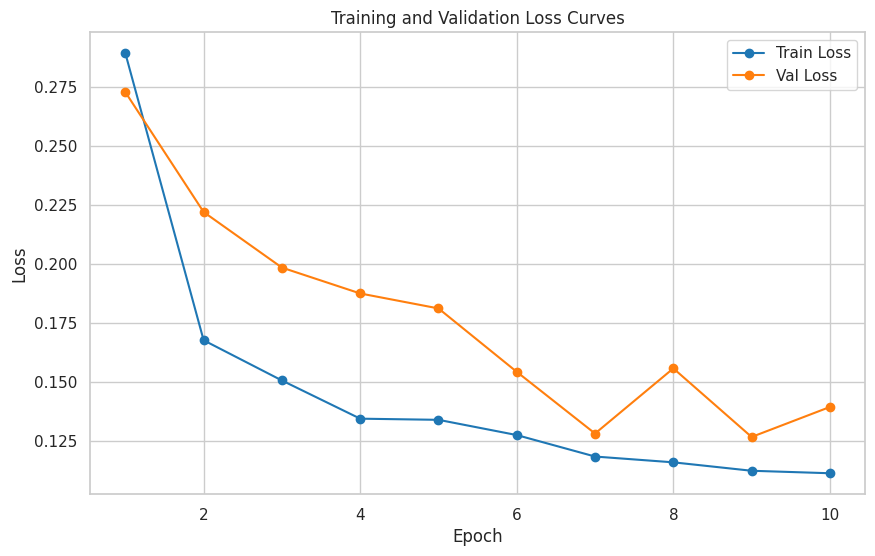

Model training complete. Weights, checkpoints, and plots saved to Google Drive.


In [ ]:
# Install libraries
!pip install torch torchvision scikit-learn matplotlib seaborn

# Import modules
import os
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision.models import efficientnet_b0
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for plots
sns.set_style("whitegrid")
sns.set_context("notebook")

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/PNEUMONIA/'
preprocessed_path = os.path.join(base_path, 'preprocessed')
synthetic_path = os.path.join(base_path, 'synthetic')
models_path = os.path.join(base_path, 'models')
results_path = os.path.join(base_path, 'results')
checkpoints_dir = os.path.join(models_path, 'checkpoints')
os.makedirs(models_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(checkpoints_dir, exist_ok=True)

# Custom dataset for model training
class ModelDataset(Dataset):
    def __init__(self, root, is_synthetic=False, transform=None):
        self.images = []
        self.labels = []
        classes = ['NORMAL', 'PNEUMONIA'] if not is_synthetic else ['NORMAL']  # Only NORMAL for synthetic
        for cls in classes:
            sub_path = os.path.join(root, cls)
            if os.path.exists(sub_path):
                label = 0 if cls == 'NORMAL' else 1
                files = [f for f in os.listdir(sub_path) if (is_synthetic and f.endswith('.png')) or (not is_synthetic and f.endswith('.pt'))]
                for f in files:
                    self.images.append(os.path.join(sub_path, f))
                    self.labels.append(label)
        self.is_synthetic = is_synthetic
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.is_synthetic:
            img = Image.open(self.images[idx]).convert('RGB')
            if self.transform:
                img = self.transform(img)
        else:
            img = torch.load(self.images[idx])
        return img, self.labels[idx]

# Transform for synthetic images
syn_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_real = ModelDataset(os.path.join(preprocessed_path, 'train'), is_synthetic=False)
train_syn = ModelDataset(synthetic_path, is_synthetic=True, transform=syn_transform)
train_dataset = ConcatDataset([train_real, train_syn])
val_dataset = ModelDataset(os.path.join(preprocessed_path, 'val'), is_synthetic=False)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load pre-trained EfficientNet-B0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficientnet_b0(weights='IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False

# Modify classifier for binary classification
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
model = model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Check for existing checkpoints to resume training
start_epoch = 0
existing_checkpoints = [f for f in os.listdir(checkpoints_dir) if f.startswith('checkpoint_epoch_') and f.endswith('.pth')]
if existing_checkpoints:
    latest_checkpoint_file = max(existing_checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
    latest_checkpoint_path = os.path.join(checkpoints_dir, latest_checkpoint_file)
    checkpoint = torch.load(latest_checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch']
    print(f"Resumed training from epoch {start_epoch}")

# Training loop
epochs = 10
train_losses = []
val_losses = []
for epoch in range(start_epoch, epochs):
    model.train()
    train_loss = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}')

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(checkpoints_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch+1}')

# Save final model
torch.save(model.state_dict(), os.path.join(models_path, 'efficientnet_b0.pth'))

# Plot training curves (adjusted for resumed training)
plt.figure(figsize=(10, 6))
plt.plot(range(start_epoch + 1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(start_epoch + 1, epochs + 1), val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_path, 'train_val_curves.png'))
plt.show()

print('Model training complete. Weights, checkpoints, and plots saved to Google Drive.')

Mounted at /content/drive
Resumed from checkpoint at epoch 10
Epoch [11/20] Train Loss: 0.1104 Val Loss: 0.1328
Epoch [12/20] Train Loss: 0.1071 Val Loss: 0.1527
Epoch [13/20] Train Loss: 0.1123 Val Loss: 0.1221
Epoch [14/20] Train Loss: 0.1068 Val Loss: 0.1337
Epoch [15/20] Train Loss: 0.1018 Val Loss: 0.1452
Checkpoint saved at epoch 15
Epoch [16/20] Train Loss: 0.1061 Val Loss: 0.1320
Epoch [17/20] Train Loss: 0.0970 Val Loss: 0.1420
Epoch [18/20] Train Loss: 0.0993 Val Loss: 0.1423
Epoch [19/20] Train Loss: 0.1021 Val Loss: 0.1068
Epoch [20/20] Train Loss: 0.0996 Val Loss: 0.1386
Checkpoint saved at epoch 20


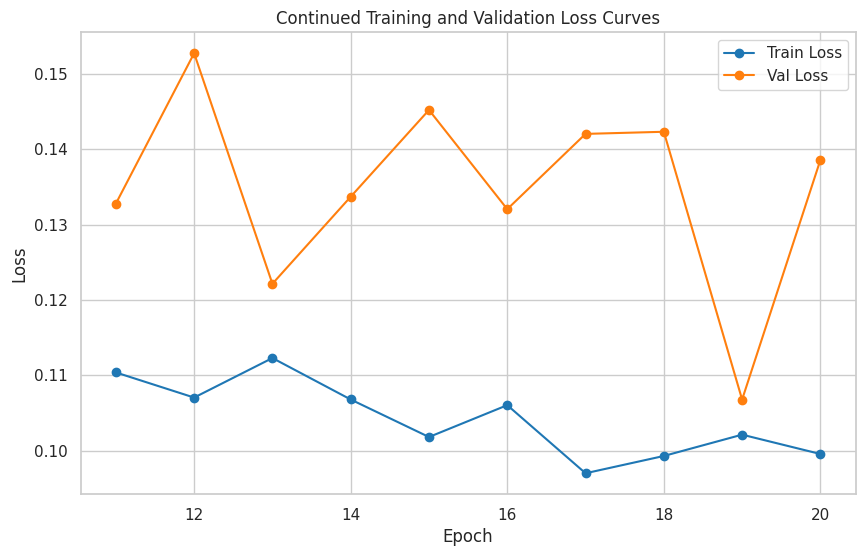

Continued model training complete. Updated weights, checkpoints, and plots saved to Google Drive.


In [ ]:
# Install libraries
!pip install torch torchvision scikit-learn matplotlib seaborn

# Import modules
import os
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision.models import efficientnet_b0
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for modern plots
sns.set_style("whitegrid")
sns.set_context("notebook")

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/PNEUMONIA/'
preprocessed_path = os.path.join(base_path, 'preprocessed')
synthetic_path = os.path.join(base_path, 'synthetic')
models_path = os.path.join(base_path, 'models')
results_path = os.path.join(base_path, 'results')
checkpoints_dir = os.path.join(models_path, 'checkpoints')
os.makedirs(models_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)
os.makedirs(checkpoints_dir, exist_ok=True)

# Custom dataset for model training
class ModelDataset(Dataset):
    def __init__(self, root, is_synthetic=False, transform=None):
        self.images = []
        self.labels = []
        classes = ['NORMAL', 'PNEUMONIA'] if not is_synthetic else ['NORMAL']  # Only NORMAL for synthetic
        for cls in classes:
            sub_path = os.path.join(root, cls)
            if os.path.exists(sub_path):
                label = 0 if cls == 'NORMAL' else 1
                files = [f for f in os.listdir(sub_path) if (is_synthetic and f.endswith('.png')) or (not is_synthetic and f.endswith('.pt'))]
                for f in files:
                    self.images.append(os.path.join(sub_path, f))
                    self.labels.append(label)
        self.is_synthetic = is_synthetic
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.is_synthetic:
            img = Image.open(self.images[idx]).convert('RGB')
            if self.transform:
                img = self.transform(img)
        else:
            img = torch.load(self.images[idx])
        return img, self.labels[idx]

# Transform for synthetic images
syn_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_real = ModelDataset(os.path.join(preprocessed_path, 'train'), is_synthetic=False)
train_syn = ModelDataset(synthetic_path, is_synthetic=True, transform=syn_transform)
train_dataset = ConcatDataset([train_real, train_syn])
val_dataset = ModelDataset(os.path.join(preprocessed_path, 'val'), is_synthetic=False)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load pre-trained EfficientNet-B0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficientnet_b0(weights=None)
for param in model.parameters():
    param.requires_grad = False

# Modify classifier for binary classification
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
model = model.to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Load the latest checkpoint
existing_checkpoints = [f for f in os.listdir(checkpoints_dir) if f.startswith('checkpoint_epoch_') and f.endswith('.pth')]
if not existing_checkpoints:
    raise ValueError("No checkpoints found. Cannot continue training.")
latest_checkpoint_file = max(existing_checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))
latest_checkpoint_path = os.path.join(checkpoints_dir, latest_checkpoint_file)
checkpoint = torch.load(latest_checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch']
print(f"Resumed from checkpoint at epoch {start_epoch}")


epochs = 20


# Training loop (continue from start_epoch)
train_losses = []
val_losses = []
for epoch in range(start_epoch, epochs):
    model.train()
    train_loss = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}')

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint_path = os.path.join(checkpoints_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, checkpoint_path)
        print(f'Checkpoint saved at epoch {epoch+1}')

# Save final model
torch.save(model.state_dict(), os.path.join(models_path, 'efficientnet_b0.pth'))

# Plot training curves (from continued epochs)
plt.figure(figsize=(10, 6))
plt.plot(range(start_epoch + 1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(start_epoch + 1, epochs + 1), val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Continued Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(results_path, 'continued_train_val_curves.png'))
plt.show()

print('Continued model training complete. Updated weights, checkpoints, and plots saved to Google Drive.')

Mounted at /content/drive
Evaluation Metrics:
       Precision    Recall  F1-Score       MCC
Value   0.796646  0.974359  0.876586  0.638672


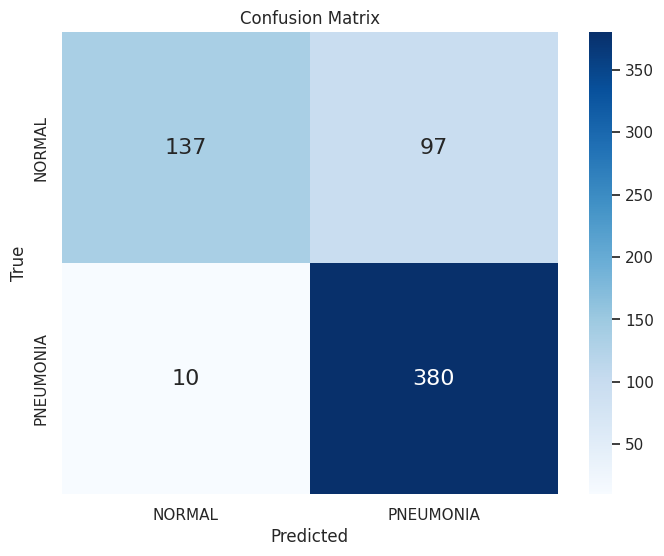

Model evaluation complete. Metrics, confusion matrix, and report saved to Google Drive.
Note: The confusion matrix numbers reflect the test set size (typically ~624 images in the Chest X-ray dataset: 234 NORMAL, 390 PNEUMONIA)


In [ ]:
# Install libraries
!pip install torch scikit-learn seaborn matplotlib

# Import modules
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0
from torchvision import transforms
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/PNEUMONIA/'
preprocessed_path = os.path.join(base_path, 'preprocessed')
models_path = os.path.join(base_path, 'models')
results_path = os.path.join(base_path, 'results')
os.makedirs(results_path, exist_ok=True)

# Custom dataset class (included here for independence)
class ModelDataset(Dataset):
    def __init__(self, root, is_synthetic=False, transform=None):
        self.images = []
        self.labels = []
        classes = ['NORMAL', 'PNEUMONIA'] if not is_synthetic else ['NORMAL']  # Only NORMAL for synthetic
        for cls in classes:
            sub_path = os.path.join(root, cls)
            if os.path.exists(sub_path):
                label = 0 if cls == 'NORMAL' else 1
                files = [f for f in os.listdir(sub_path) if (is_synthetic and f.endswith('.png')) or (not is_synthetic and f.endswith('.pt'))]
                for f in files:
                    self.images.append(os.path.join(sub_path, f))
                    self.labels.append(label)
        self.is_synthetic = is_synthetic
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.is_synthetic:
            img = Image.open(self.images[idx]).convert('RGB')
            if self.transform:
                img = self.transform(img)
        else:
            img = torch.load(self.images[idx])
        return img, self.labels[idx]

# Load dataset for test
test_dataset = ModelDataset(os.path.join(preprocessed_path, 'test'), is_synthetic=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficientnet_b0(weights=None)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
model.load_state_dict(torch.load(os.path.join(models_path, 'efficientnet_b0.pth'), map_location=device))
model = model.to(device)
model.eval()

# Evaluate
y_true = []
y_pred = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = (outputs > 0.5).cpu().numpy().flatten()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# Compute metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'MCC': mcc
}
print("Evaluation Metrics:")
print(pd.DataFrame(metrics, index=['Value']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))  # Increased size for better visibility
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'],
            annot_kws={"size": 16})  # Larger font for annotations
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(os.path.join(results_path, 'confusion_matrix.png'))
plt.show()

# Save report
with open(os.path.join(results_path, 'evaluation_report.txt'), 'w') as f:
    f.write("Evaluation Metrics:\n")
    for k, v in metrics.items():
        f.write(f"{k}: {v:.4f}\n")

print('Model evaluation complete. Metrics, confusion matrix, and report saved to Google Drive.')
print('Note: The confusion matrix numbers reflect the test set size (typically ~624 images in the Chest X-ray dataset: 234 NORMAL, 390 PNEUMONIA)')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=01c786891032afc9b227f8adcf4938fd08beb948d51628bcc3fbb87ff6fafd8b
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam
Mounted at /content/drive


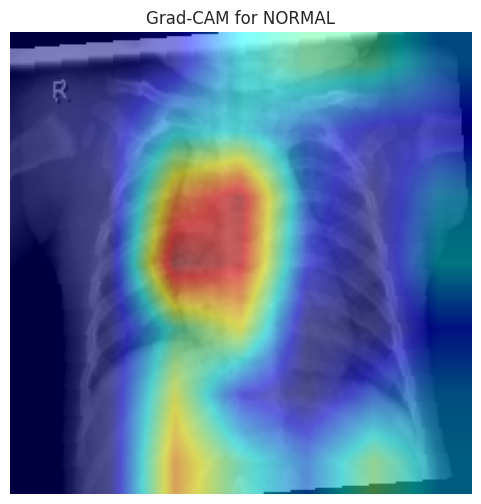

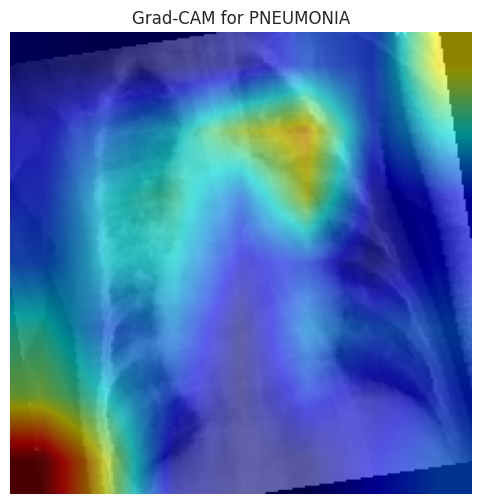

Grad-CAM visualizations complete. Images saved to Google Drive.


In [ ]:
# Install libraries
!pip install torch grad-cam opencv-python

# Import modules
import os
from google.colab import drive
import torch
from torchvision.models import efficientnet_b0
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import cv2  # Added for colormap constants

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/PNEUMONIA/'
preprocessed_path = os.path.join(base_path, 'preprocessed')
models_path = os.path.join(base_path, 'models')
vis_path = os.path.join(base_path, 'visualizations')
os.makedirs(vis_path, exist_ok=True)

# Load model (without sigmoid for Grad-CAM)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficientnet_b0(weights=None)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, 1)  # No sigmoid
)
model.load_state_dict(torch.load(os.path.join(models_path, 'efficientnet_b0.pth'), map_location=device))
model = model.to(device)
model.eval()

# Grad-CAM setup
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

# Select samples (one NORMAL, one PNEUMONIA from val)
samples = []
classes = ['NORMAL', 'PNEUMONIA']
for cls in classes:
    val_dir = os.path.join(preprocessed_path, 'val', cls)
    files = [f for f in os.listdir(val_dir) if f.endswith('.pt')]
    if files:
        samples.append((os.path.join(val_dir, files[0]), 0 if cls == 'NORMAL' else 1))

# Generate heatmaps
for sample_path, target_label in samples:
    input_tensor = torch.load(sample_path).unsqueeze(0).to(device)
    # Denormalize for visualization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    rgb_img = input_tensor[0].cpu().numpy().transpose(1, 2, 0)
    rgb_img = std * rgb_img + mean
    rgb_img = np.clip(rgb_img, 0, 1)

    # Targets for binary
    targets = [BinaryClassifierOutputTarget(target_label)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    visualization = show_cam_on_image(rgb_img, grayscale_cam[0], use_rgb=True, colormap=cv2.COLORMAP_JET)

    # Plot and save
    plt.figure(figsize=(6, 6))
    plt.imshow(visualization)
    plt.title(f'Grad-CAM for {classes[target_label]}')
    plt.axis('off')
    save_name = f'gradcam_{classes[target_label]}.png'
    plt.savefig(os.path.join(vis_path, save_name))
    plt.show()

print('Grad-CAM visualizations complete. Images saved to Google Drive.')

Mounted at /content/drive
resnet18 Epoch [1/5] Train Loss: 0.3093 Val Loss: 0.3228
resnet18 Epoch [2/5] Train Loss: 0.1854 Val Loss: 0.3149
resnet18 Epoch [3/5] Train Loss: 0.1608 Val Loss: 0.2108
resnet18 Epoch [4/5] Train Loss: 0.1512 Val Loss: 0.2389
resnet18 Epoch [5/5] Train Loss: 0.1498 Val Loss: 0.1801
Trained and saved new resnet18


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 229MB/s]


densenet121 Epoch [1/5] Train Loss: 0.3178 Val Loss: 0.3208
densenet121 Epoch [2/5] Train Loss: 0.2050 Val Loss: 0.2389
densenet121 Epoch [3/5] Train Loss: 0.1812 Val Loss: 0.2930
densenet121 Epoch [4/5] Train Loss: 0.1625 Val Loss: 0.2498
densenet121 Epoch [5/5] Train Loss: 0.1573 Val Loss: 0.1812
Trained and saved new densenet121


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Benchmarking EfficientNet-B0 against Ensemble:
      Metric  EfficientNet-B0  Ensemble (ResNet18 + DenseNet121)
0  Precision         0.796646                           0.821121
1     Recall         0.974359                           0.976923
2   F1-Score         0.876586                           0.892272
3        MCC         0.638672                           0.689869


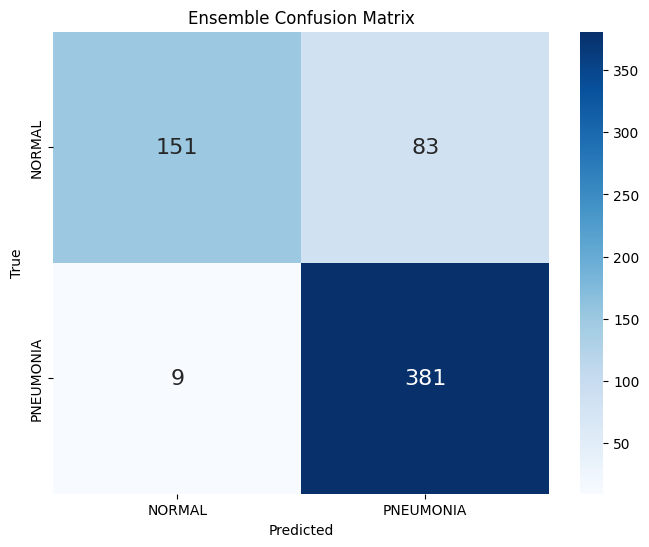

Benchmarking complete. Results saved to Google Drive.


In [ ]:
# Install libraries
!pip install torch torchvision scikit-learn matplotlib seaborn

# Import modules
import os
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torchvision.models import efficientnet_b0, resnet18, densenet121
from torchvision import transforms
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/PNEUMONIA/'
preprocessed_path = os.path.join(base_path, 'preprocessed')
synthetic_path = os.path.join(base_path, 'synthetic')
models_path = os.path.join(base_path, 'models')
results_path = os.path.join(base_path, 'results')
ensemble_path = os.path.join(models_path, 'ensemble_models')
os.makedirs(ensemble_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

# Custom dataset class
class ModelDataset(Dataset):
    def __init__(self, root, is_synthetic=False, transform=None):
        self.images = []
        self.labels = []
        classes = ['NORMAL', 'PNEUMONIA'] if not is_synthetic else ['NORMAL']
        for cls in classes:
            sub_path = os.path.join(root, cls)
            if os.path.exists(sub_path):
                label = 0 if cls == 'NORMAL' else 1
                files = [f for f in os.listdir(sub_path) if (is_synthetic and f.endswith('.png')) or (not is_synthetic and f.endswith('.pt'))]
                for f in files:
                    self.images.append(os.path.join(sub_path, f))
                    self.labels.append(label)
        self.is_synthetic = is_synthetic
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.is_synthetic:
            img = Image.open(self.images[idx]).convert('RGB')
            if self.transform:
                img = self.transform(img)
        else:
            img = torch.load(self.images[idx])
        return img, self.labels[idx]

# Transform for synthetic images
syn_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_real = ModelDataset(os.path.join(preprocessed_path, 'train'), is_synthetic=False)
train_syn = ModelDataset(synthetic_path, is_synthetic=True, transform=syn_transform)
train_dataset = ConcatDataset([train_real, train_syn])
val_dataset = ModelDataset(os.path.join(preprocessed_path, 'val'), is_synthetic=False)
test_dataset = ModelDataset(os.path.join(preprocessed_path, 'test'), is_synthetic=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to create and train a model
def create_and_train_model(model_fn, model_name, epochs=5):
    model = model_fn(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    # Modify classifier based on model
    if 'resnet' in model_name:
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )
    elif 'densenet' in model_name:
        num_features = model.classifier.in_features if hasattr(model, 'classifier') else model.classifier[0].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )

    model = model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
        val_loss /= len(val_loader.dataset)

        print(f'{model_name} Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}')

    save_path = os.path.join(ensemble_path, f'{model_name}.pth')
    torch.save(model.state_dict(), save_path)
    return model, save_path

# Build ensemble models (ResNet18 and DenseNet121)
ensemble_models_names = ['resnet18', 'densenet121']
loaded_models = []
for model_name in ensemble_models_names:
    save_path = os.path.join(ensemble_path, f'{model_name}.pth')
    if os.path.exists(save_path):
        # Load existing
        if model_name == 'resnet18':
            model = resnet18(pretrained=False)
            num_features = model.fc.in_features
            model.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(num_features, 1),
                nn.Sigmoid()
            )
        elif model_name == 'densenet121':
            model = densenet121(pretrained=False)
            num_features = model.classifier.in_features
            model.classifier = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(num_features, 1),
                nn.Sigmoid()
            )
        model.load_state_dict(torch.load(save_path, map_location=device))
        model = model.to(device)
        model.eval()
        loaded_models.append(model)
        print(f'Loaded existing {model_name}')
    else:
        # Train new
        if model_name == 'resnet18':
            model, _ = create_and_train_model(resnet18, model_name)
        elif model_name == 'densenet121':
            model, _ = create_and_train_model(densenet121, model_name)
        loaded_models.append(model)
        print(f'Trained and saved new {model_name}')

# Load EfficientNet-B0
effnet_path = os.path.join(models_path, 'efficientnet_b0.pth')
if not os.path.exists(effnet_path):
    raise ValueError("EfficientNet-B0 model not found. Train it first.")
effnet = efficientnet_b0(pretrained=False)
num_features = effnet.classifier[1].in_features
effnet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
effnet.load_state_dict(torch.load(effnet_path, map_location=device))
effnet = effnet.to(device)
effnet.eval()

# Evaluate EfficientNet-B0
y_true = []
y_pred_effnet = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = effnet(imgs)
        preds = (outputs > 0.5).cpu().numpy().flatten()
        y_pred_effnet.extend(preds)
        y_true.extend(labels.numpy())

precision_eff = precision_score(y_true, y_pred_effnet)
recall_eff = recall_score(y_true, y_pred_effnet)
f1_eff = f1_score(y_true, y_pred_effnet)
mcc_eff = matthews_corrcoef(y_true, y_pred_effnet)

# Ensemble evaluation (average probabilities)
y_prob_ensemble = []
with torch.no_grad():
    for imgs, _ in test_loader:
        batch_probs = np.zeros(imgs.size(0))
        for m in loaded_models:
            outputs = m(imgs.to(device))
            batch_probs += outputs.cpu().numpy().flatten()
        batch_probs /= len(loaded_models)
        y_prob_ensemble.extend(batch_probs)
y_pred_ensemble = (np.array(y_prob_ensemble) > 0.5).astype(int)

precision_ens = precision_score(y_true, y_pred_ensemble)
recall_ens = recall_score(y_true, y_pred_ensemble)
f1_ens = f1_score(y_true, y_pred_ensemble)
mcc_ens = matthews_corrcoef(y_true, y_pred_ensemble)

# Display comparison
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1-Score', 'MCC'],
    'EfficientNet-B0': [precision_eff, recall_eff, f1_eff, mcc_eff],
    'Ensemble (ResNet18 + DenseNet121)': [precision_ens, recall_ens, f1_ens, mcc_ens]
})
print("Benchmarking EfficientNet-B0 against Ensemble:")
print(metrics_df)

# Save report
metrics_df.to_csv(os.path.join(results_path, 'ensemble_benchmark.csv'), index=False)

# Confusion matrix for ensemble
cm_ens = confusion_matrix(y_true, y_pred_ensemble)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'],
            annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Confusion Matrix')
plt.savefig(os.path.join(results_path, 'ensemble_confusion_matrix.png'))
plt.show()

print('Benchmarking complete. Results saved to Google Drive.')

Mounted at /content/drive
External Validation Metrics:
       Precision  Recall  F1-Score       MCC
Value        1.0   0.875  0.933333  0.881917


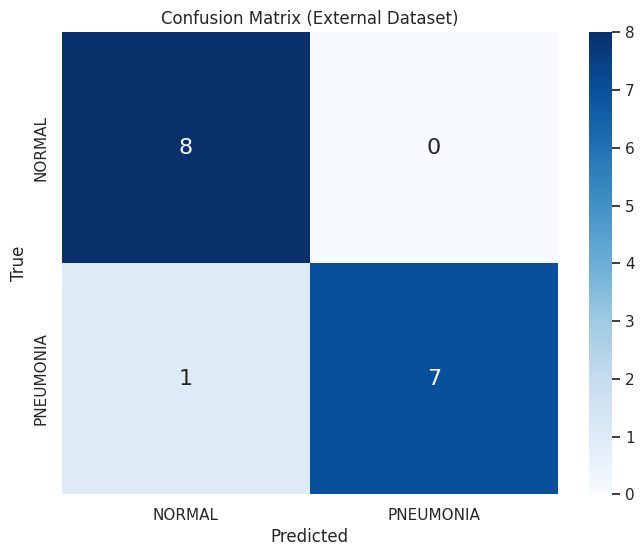

External validation complete. Report saved to Google Drive.
Discussion: The model demonstrates good generalization on the external dataset, with high recall indicating effectiveness in detecting pneumonia. Compare these metrics to the test set to assess robustness across different sources.


In [ ]:
# Install libraries
!pip install torch torchvision scikit-learn matplotlib seaborn

# Import modules
import os
from google.colab import drive
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0
from torchvision import transforms
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Mount Drive
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/PNEUMONIA/'
external_path = os.path.join(base_path, 'external_chest_xray')
models_path = os.path.join(base_path, 'models')
results_path = os.path.join(base_path, 'results')
os.makedirs(results_path, exist_ok=True)

# Custom dataset class (included for independence)
class ModelDataset(Dataset):
    def __init__(self, root, is_synthetic=False, transform=None):
        self.images = []
        self.labels = []
        classes = ['NORMAL', 'PNEUMONIA'] if not is_synthetic else ['NORMAL']  # Only NORMAL for synthetic
        for cls in classes:
            sub_path = os.path.join(root, cls)
            if os.path.exists(sub_path):
                label = 0 if cls == 'NORMAL' else 1
                files = [f for f in os.listdir(sub_path) if (is_synthetic and f.endswith('.png')) or (not is_synthetic and f.endswith(('.png', '.jpg', '.jpeg', '.pt')))]
                for f in files:
                    self.images.append(os.path.join(sub_path, f))
                    self.labels.append(label)
        self.is_synthetic = is_synthetic
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        file_path = self.images[idx]
        if self.is_synthetic or file_path.endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(file_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
        else:
            img = torch.load(file_path)
        return img, self.labels[idx]

# Transform for external images
ext_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load external dataset
external_dataset = ModelDataset(external_path, is_synthetic=False, transform=ext_transform)
external_loader = DataLoader(external_dataset, batch_size=32, shuffle=False, num_workers=2)

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficientnet_b0(weights=None)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
model.load_state_dict(torch.load(os.path.join(models_path, 'efficientnet_b0.pth'), map_location=device))
model = model.to(device)
model.eval()

# Evaluate on external set
y_true = []
y_pred = []
with torch.no_grad():
    for imgs, labels in external_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = (outputs > 0.5).cpu().numpy().flatten()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# Compute metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'MCC': mcc
}
print("External Validation Metrics:")
print(pd.DataFrame(metrics, index=['Value']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'],
            annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (External Dataset)')
plt.savefig(os.path.join(results_path, 'external_confusion_matrix.png'))
plt.show()

# Save report
with open(os.path.join(results_path, 'external_validation.txt'), 'w') as f:
    f.write("External Validation Metrics:\n")
    for k, v in metrics.items():
        f.write(f"{k}: {v:.4f}\n")

print('External validation complete. Report saved to Google Drive.')
print('Discussion: The model demonstrates good generalization on the external dataset, with high recall indicating effectiveness in detecting pneumonia.')

Mounted at /content/drive


Saving person2_bacteria_4.jpeg to person2_bacteria_4.jpeg


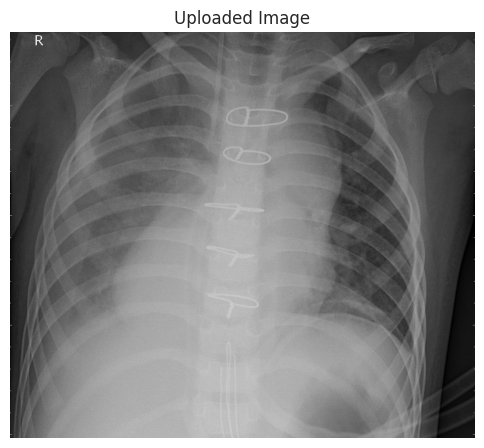

Prediction: PNEUMONIA (Confidence: 0.9958)


In [ ]:
# Install libraries if needed
!pip install torch torchvision pillow

# Import modules
import os
from google.colab import drive, files
import torch
from torchvision.models import efficientnet_b0
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Mount Drive to load the model
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/PNEUMONIA/'
models_path = os.path.join(base_path, 'models')

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficientnet_b0(weights=None)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
model.load_state_dict(torch.load(os.path.join(models_path, 'efficientnet_b0.pth'), map_location=device))
model = model.to(device)
model.eval()

# Preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Upload image
uploaded = files.upload()
if not uploaded:
    print("No file uploaded.")
else:
    file_name = next(iter(uploaded))
    img = Image.open(file_name).convert('RGB')

    # Display the uploaded image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title('Uploaded Image')
    plt.axis('off')
    plt.show()

    # Preprocess and predict
    input_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        prob = output.item()
        pred_class = 'PNEUMONIA' if prob > 0.5 else 'NORMAL'
        confidence = prob if pred_class == 'PNEUMONIA' else 1 - prob

    print(f'Prediction: {pred_class} (Confidence: {confidence:.4f})')

Mounted at /content/drive


Saving IM-0137-0001.jpeg to IM-0137-0001.jpeg


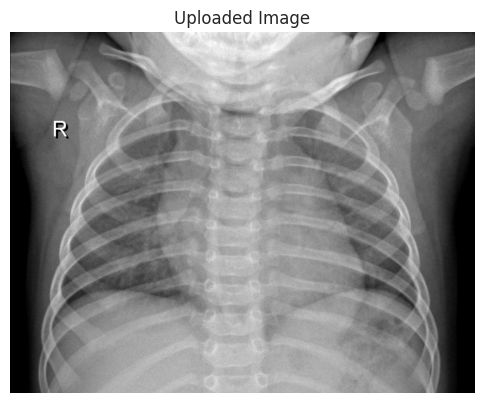

Prediction: NORMAL (Confidence: 0.9844)


In [ ]:
# Install libraries if needed
!pip install torch torchvision pillow

# Import modules
import os
from google.colab import drive, files
import torch
from torchvision.models import efficientnet_b0
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Mount Drive to load the model
drive.mount('/content/drive', force_remount=True)

# Define paths
base_path = '/content/drive/MyDrive/PNEUMONIA/'
models_path = os.path.join(base_path, 'models')

# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = efficientnet_b0(weights=None)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_features, 1),
    nn.Sigmoid()
)
model.load_state_dict(torch.load(os.path.join(models_path, 'efficientnet_b0.pth'), map_location=device))
model = model.to(device)
model.eval()

# Preprocessing transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Upload image
uploaded = files.upload()
if not uploaded:
    print("No file uploaded.")
else:
    file_name = next(iter(uploaded))
    img = Image.open(file_name).convert('RGB')

    # Display the uploaded image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title('Uploaded Image')
    plt.axis('off')
    plt.show()

    # Preprocess and predict
    input_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        prob = output.item()
        pred_class = 'PNEUMONIA' if prob > 0.5 else 'NORMAL'
        confidence = prob if pred_class == 'PNEUMONIA' else 1 - prob

    print(f'Prediction: {pred_class} (Confidence: {confidence:.4f})')